Text(0.5,0,'X2')

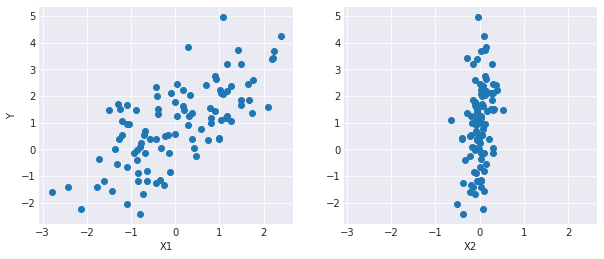

In [4]:
### Generate data

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

%matplotlib inline
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2')

In [5]:
### Apply parameter estimation by pymc3

import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

# Specify model
basic_model = pm.Model()

with basic_model:
    # describe prior distributions of model parameters. Stochastic variables
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
    # specify model for the output parameter. Deterministic variable
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # likelihood of the observations. Observed stochastic variable
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

    
# model fitting by using maximum a posteriori    
map_estimate = pm.find_MAP(model=basic_model)    
print (map_estimate)    
    
    


Running on PyMC3 v3.5


logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 1409.92it/s]  


{'alpha': array(0.90660093), 'beta': array([0.94848596, 2.60711845]), 'sigma_log__': array(-0.03771373), 'sigma': array(0.96298858)}


In [10]:
### For comparison: parameter estimation without ppl
from sklearn import linear_model

scipy_model = linear_model.LinearRegression()
scipy_model.fit(np.transpose(np.array([X1,X2])),Y)

print(scipy_model.coef_)
print(scipy_model.intercept_)

[0.94857558 2.61356071]
0.9067064515219792


In [8]:
# model fitting by using sampling strategies


with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)


trace['beta'][-5:]



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 4031.59draws/s]


array([[0.95120499, 2.54820963],
       [0.89992334, 2.28405512],
       [0.94672779, 2.14127217],
       [0.88395349, 2.75641941],
       [0.88395349, 2.75641941]])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.91,0.10,0.00,0.72,1.09,3607.77,1.0
beta__0,0.95,0.09,0.00,0.78,1.13,3094.32,1.0
beta__1,2.60,0.51,0.01,1.65,3.68,2533.38,1.0
sigma,0.99,0.07,0.00,0.86,1.13,2335.76,1.0


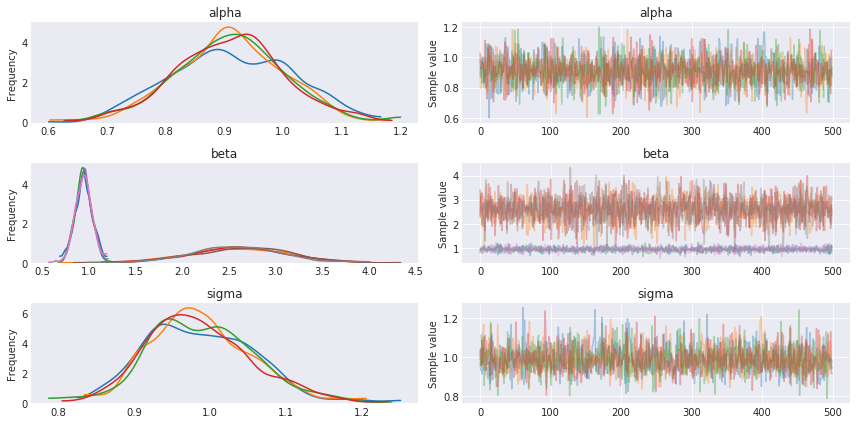

In [10]:
# Posterior analysis

pm.traceplot(trace);

pm.summary(trace).round(2)


In [ ]:
## urn example from Stuhlmüller

# We have 3 urns with unknown number of red and black balls. 
# Proportion of red to black balls in each urn is unknown.
# It is possible, but not known, if the proportions in the urns are similar.

with pm.Model() as urn_model:
    bias = Uniform([0,1])

# query: What is the proportion of red to black balls in the third urn?

# Evidence: 15 balls were drawn from the first urn, 14 of them were red,
# one was black